导入必要的库

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


数据加载预处理

In [9]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
#加载minist数据集
train_data=datasets.MNIST(root='./data',train=True,transform=transform,download=True)
train_loader=DataLoader(train_data,batch_size=64,shuffle=True)

定义生成器和判别器

In [10]:
# 检查CUDA（GPU支持）是否可用
cuda_available = torch.cuda.is_available()
print("CUDA Available:", cuda_available)
device = torch.device("cuda" if cuda_available else "cpu")

class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.main = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )
    def forward(self,input):
        return self.main(input).view(-1,1,28,28)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.main = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self,input):
        input=input.view(-1,28*28)
        return self.main(input)


CUDA Available: True


初始化模型，损失函数和优化器

In [11]:
generator=Generator()
generator.to(device)
discriminator=Discriminator()
discriminator.to(device)

#损失函数
loss_function=nn.BCELoss()

#优化器
optimizer_g=optim.Adam(generator.parameters(),lr=0.0002)
optimizer_d=optim.Adam(discriminator.parameters(),lr=0.0002)

开始训练

In [21]:
epochs = 50
for epoch in range(epochs):
    for i, (images, _) in enumerate(train_loader):
        # 训练判别器
        discriminator.zero_grad()
        real_data = images.to(device)
        # 生成真实图像标签和假的图像标签
        real_labels = torch.ones(images.size(0), 1).to(device)
        fake_labels = torch.zeros(images.size(0), 1).to(device)

        # 训练判别器去识别真实图像
        outputs = discriminator(real_data)
        real_loss = loss_function(outputs, real_labels)
        real_score = outputs

        # 训练判别器去识别假的图像
        noise = torch.randn(images.size(0), 100).to(device)
        fake_data = generator(noise)
        outputs = discriminator(fake_data.detach())
        fake_loss = loss_function(outputs, fake_labels)
        fake_score = outputs

        # 总的判别器损失
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_d.step()

        # 训练生成器，生成假的图像，并且训练判别器去识别假的图像，如果生成器生成的图像判别器认为是假的图像，
        #那么对应真实标签去计算损失就一定很高，反之如果判别器认为是真的图像，那么对应真的标签去计算损失就会很低
        generator.zero_grad()
        # 生成器试图欺骗判别器，因此使用真实标签
        outputs = discriminator(fake_data)
        g_loss = loss_function(outputs, real_labels)

        g_loss.backward()
        optimizer_g.step()
    print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, '
          'D(x): {:.2f}, D(G(z)): {:.2f}'.format(epoch, epochs, d_loss.item(), g_loss.item(),
                                                  real_score.mean().item(), fake_score.mean().item()))


RuntimeError: Trying to backward through the graph a second time, but the saved intermediate results have already been freed. Specify retain_graph=True when calling backward the first time.

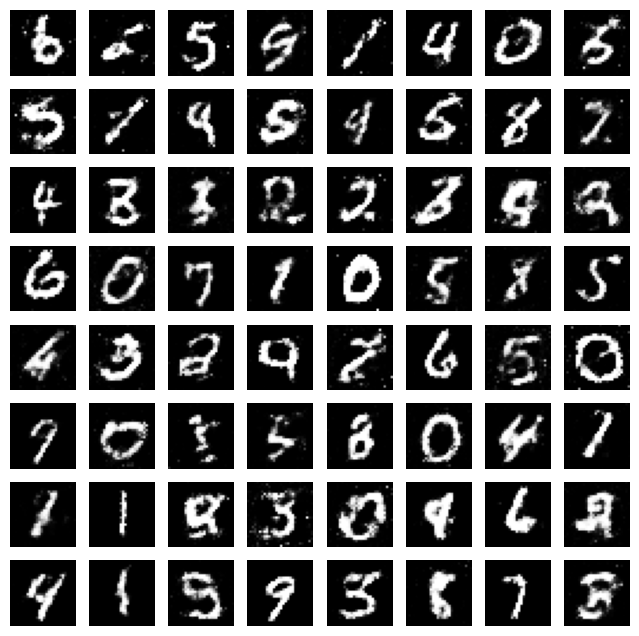

In [13]:
# 生成图像
with torch.no_grad():
    fixed_noise = torch.randn(64, 100).to(device)
    fake_images = generator(fixed_noise).cpu()
#显示图片
fig = plt.figure(figsize=(8, 8))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(fake_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

